**Segmentación con el modelo pre-entrenado YOLO v8 para intentar segmentar automoviles vistos de una foto elevada.**

**El modelo YOLOv8 está entrenado para detección de objetos urbanos: aurtos, personas, letreros, semáforos, etc.**

Primero instalamos la librería de "ultralytics", que es la que contiene el modelo pre-entrenado YOLOv8

In [30]:
!pip install -q ultralytics

Luego importamos las librerías de OpenCV, Matplolib, PIL, Numpy y el montaje de Google Drive

In [31]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos el modelo YOLOv8 para segmentación

In [32]:
model = YOLO("yolov8s-seg.pt")

Cargamos las imágenes con las que vamos a trabajar desde Google Drive, y las convertimos de BGR a RGB

In [35]:
image_paths = [
    "/content/drive/MyDrive/imagenesColab/Cars/car1.png",
    "/content/drive/MyDrive/imagenesColab/Cars/car2.png",
    "/content/drive/MyDrive/imagenesColab/Cars/car3.png"
]
images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in image_paths]

Ejecutamos la inferencia con el modelo YOLOv8, Superponemos las máscaras en color verde sobre las imagenes y hacemos un arreglo de imagenes solo para mostralas horizontalmente


image 1/1 /content/drive/MyDrive/imagenesColab/Cars/car1.png: 416x640 2 cars, 572.7ms
Speed: 2.0ms preprocess, 572.7ms inference, 7.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/drive/MyDrive/imagenesColab/Cars/car2.png: 448x640 1 car, 7 cell phones, 876.6ms
Speed: 2.5ms preprocess, 876.6ms inference, 22.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/drive/MyDrive/imagenesColab/Cars/car3.png: 448x640 1 bottle, 14 cell phones, 691.2ms
Speed: 3.0ms preprocess, 691.2ms inference, 41.4ms postprocess per image at shape (1, 3, 448, 640)


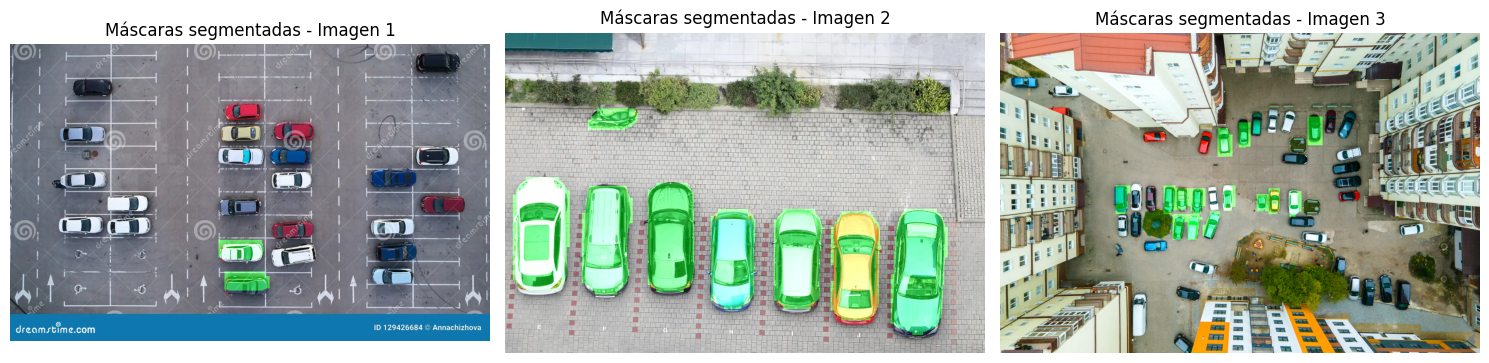

In [36]:
results_list = [model(p)[0] for p in image_paths]
annotated_images = []

for img, res in zip(images, results_list):
    annotated = img.copy()
    height, width = annotated.shape[:2]

    if res.masks is not None: #Verificamos que el resultado "res" contenga máscaras segmentadas
        for mask in res.masks.data: #iteración sobre cada máscara
            mask_np = mask.cpu().numpy()
            resized_mask = cv2.resize(mask_np, (width, height), interpolation=cv2.INTER_NEAREST) #mantenemos la interpolacion binaria
            color_mask = np.zeros_like(annotated)
            color_mask[resized_mask > 0.3] = [0, 255, 0] #pintanos de verde los píxeles de la mascara binaria
            annotated = cv2.addWeighted(annotated, 1.0, color_mask, 0.5, 0) #se superpone la mascara sobre la imagen

    annotated_images.append(annotated)


plt.figure(figsize=(15, 5))
for i, img in enumerate(annotated_images):
    plt.subplot(1, len(annotated_images), i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Máscaras segmentadas - Imagen {i+1}")
plt.tight_layout()
plt.show()


Guardamos la imágenes con las mascaras previamente calculadas (o imágenes predichas) en Google Drive para compararlas después en el ground truth y mostramos si las guardó exitosamente

In [37]:
output_dir = "/content/drive/MyDrive/imagenesColab/Cars/ground_truth"
os.makedirs(output_dir, exist_ok=True) #crea el directorio en Google Drive si es que no existe

for idx, (res, path) in enumerate(zip(results_list, image_paths)): #itera sobre los resultados de la segmentación generados por el modelo y por las rutas de las imagenes
    filename = os.path.splitext(os.path.basename(path))[0] #obtenemos el nombre del archivo sin extensión

    if res.masks is not None: #verificamos si hay realmente máscaras
        mask_combined = np.zeros(res.masks.data[0].shape, dtype=np.uint8) #se inicia una mascara vacía para combinarlas todas
        for mask in res.masks.data:
            mask_np = (mask.cpu().numpy() > 0.5).astype("uint8") #se aplica umbral de 0.5 para binarizar la máscara
            mask_combined = np.logical_or(mask_combined, mask_np) #se va acumulando las máscaras en una sola

        mask_combined = (mask_combined * 255).astype("uint8") #se convuerte la mascara binaria a escala de grises
        output_path = os.path.join(output_dir, f"{filename}_pred.png") #conbtruye la ruta final del archivo
        cv2.imwrite(output_path, mask_combined) #usamos OpenCV para guardar la imagen en formato png
        print(f"Guardada: {output_path}") #imprimimos si fue gyardado con exito el archivo


Guardada: /content/drive/MyDrive/imagenesColab/Cars/ground_truth/car1_pred.png
Guardada: /content/drive/MyDrive/imagenesColab/Cars/ground_truth/car2_pred.png
Guardada: /content/drive/MyDrive/imagenesColab/Cars/ground_truth/car3_pred.png


Mostramos las máscaras ground truth en horizontal, solo para referencia

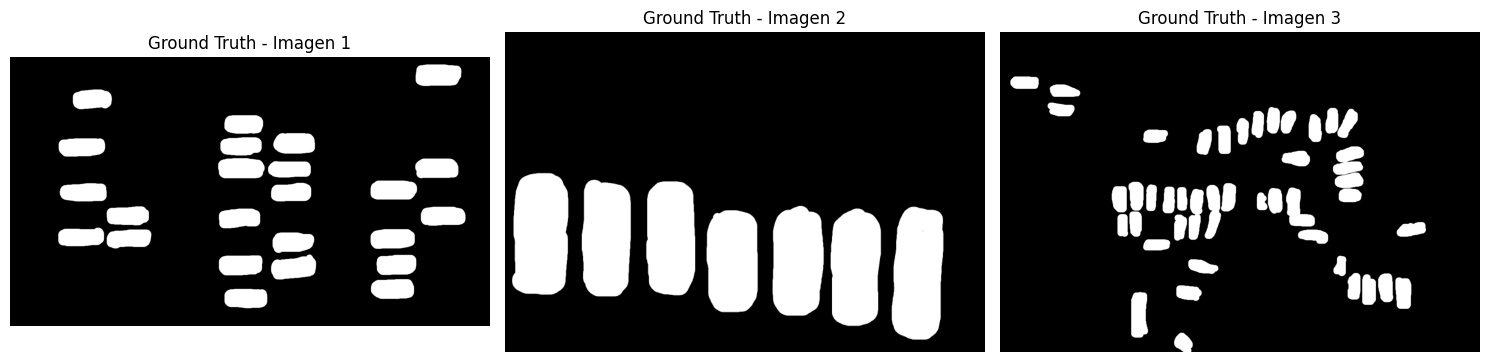

In [38]:
ground_truth_dir = "/content/drive/MyDrive/imagenesColab/Cars/ground_truth" #definimos la ruta de las mascaras ground truth en Google Drive

gt_paths = sorted(glob(os.path.join(ground_truth_dir, "*[!_pred].png"))) #buscamos las imagenes que no contienen _pred como sufijo

plt.figure(figsize=(5 * len(gt_paths), 5))
for i, gt_path in enumerate(gt_paths):
    mask = Image.open(gt_path).convert("L")
    plt.subplot(1, len(gt_paths), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Ground Truth - Imagen {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Calculamos el IoU (Intersection over Union) entre el ground truth y las predicciones.
Los valores típicos son:
IoU = 1.0 Superposición perfecta
IoU = 0.0 Ninguna superposición
IoU > 0.5 Aceptable
IoU < 0.3 Mala predicción

In [39]:
from glob import glob #permite buscar archivos que coincidan con un patrón

def calculate_iou(mask_pred, mask_gt): #compara las dos máscaras binarias
    intersection = np.logical_and(mask_pred, mask_gt).sum() #cantidad de píxeles donde ambas máscaras tienen valor positivo
    union = np.logical_or(mask_pred, mask_gt).sum() #cantidad de píxeles donde al menos una máscara es positiva
    return intersection / union if union > 0 else float('nan')

ground_truth_dir = "/content/drive/MyDrive/imagenesColab/Cars/ground_truth" #ruta de archivos de imagenes a comparar
ious = []

for gt_path in sorted(glob(os.path.join(ground_truth_dir, "*[!_pred].png"))): #iteración sobre las imagenes ground truth
    filename = os.path.basename(gt_path)
    name_base = filename.replace(".png", "")
    pred_path = os.path.join(ground_truth_dir, f"{name_base}_pred.png") #busca el archivo de máscara predicha correspondiente

    if os.path.exists(pred_path): #procede si encontró una máscara predicha
        mask_gt = np.array(Image.open(gt_path).convert("L")) #se cargan las imagenes en escala de grises
        mask_pred = np.array(Image.open(pred_path).convert("L"))
        mask_pred = cv2.resize(mask_pred, (mask_gt.shape[1], mask_gt.shape[0]), interpolation=cv2.INTER_NEAREST) #nos aseguramos que las imagenes tengan el mismo tamaño

        mask_gt_bin = mask_gt > 127 #convierte las máscaras de escala de grises a binarias usando umbral 127
        mask_pred_bin = mask_pred > 127

        iou = calculate_iou(mask_pred_bin, mask_gt_bin) #calcula la métrica del IoU
        ious.append(iou)
        print(f"IoU para {filename}: {iou:.3f}") #lmuestra el resuluado
    else:
        print(f"No se encontró predicción para {filename}") #se notifica si no existe

if ious:
    print(f"\nIoU promedio: {np.nanmean(ious):.3f}") #se muestra el promedio final
else:
    print("No se encontraron comparaciones válidas.") #mensaje si no se encontró ninguna


IoU para car1.png: 0.024
IoU para car2.png: 0.866
IoU para car3.png: 0.229

IoU promedio: 0.373


Conclusiones:
Se evaluó la segmentación de automóviles utilizando el modelo YOLOv8 con IoU como métrica de desempeño. Se obtuvo un IoU promedio de 0.373, lo cual indica una segmentación baja, con baja coincidencia general entre las máscaras predichas y las ground truth. La de mejor coincidencia fue la imagen Car2 que tiene los automoviles más grandes relativamente, lo que me hace pensar que podríamos obtener mejores resultados con objetos más cercanos.